# nuScenes devkit tutorial

Welcome to the nuScenes tutorial. Make sure you have the nuScenes DB schema available.

This demo assumes the database itself is available at `/data/sets/nuscenes`

In [1]:
# Let's start by initializing the database
%matplotlib inline
from nuscenes.nuscenes import NuScenes

nusc = NuScenes(version='v1.0-mini', dataroot='/data/exp/nuScenes-blurring-data/nuscenes-v1.0', verbose=True)

Loading NuScenes tables for version v1.0-mini ...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.6 seconds.
Reverse indexing ...
Done reverse indexing in 0.2 seconds.


In [3]:
nusc_all = NuScenes(version='v1.0', dataroot='/data/exp/nuScenes-blurring-data/nuscenes-v1.0', verbose=True)

Loading NuScenes tables for version v1.0 ...
23 category,
8 attribute,
4 visibility,
76392 instance,
12 sensor,
12000 calibrated_sensor,
3093984 ego_pose,
83 log,
1000 scene,
40157 sample,
3093984 sample_data,
1367770 sample_annotation,
4 map,
Done loading in 45.3 seconds.
Reverse indexing ...
Done reverse indexing in 14.4 seconds.


In [ ]:
nusc_test = NuScenes(version='v1.0-test', dataroot='/data/exp/nuScenes-blurring-data/nuscenes-v1.0', verbose=True)

  0%|          | 0/162 [00:00<?, ?it/s]

Adding ego poses to map...


100%|██████████| 162/162 [00:13<00:00, 11.85it/s]


Creating plot...


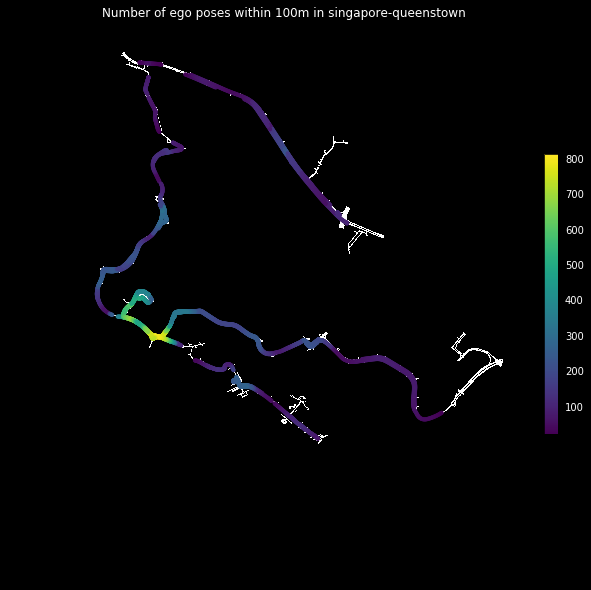

In [5]:
nusc_all.render_egoposes_on_map('singapore-queenstown')

  0%|          | 0/203 [00:00<?, ?it/s]

Adding ego poses to map...


100%|██████████| 203/203 [00:04<00:00, 41.80it/s]


Creating plot...


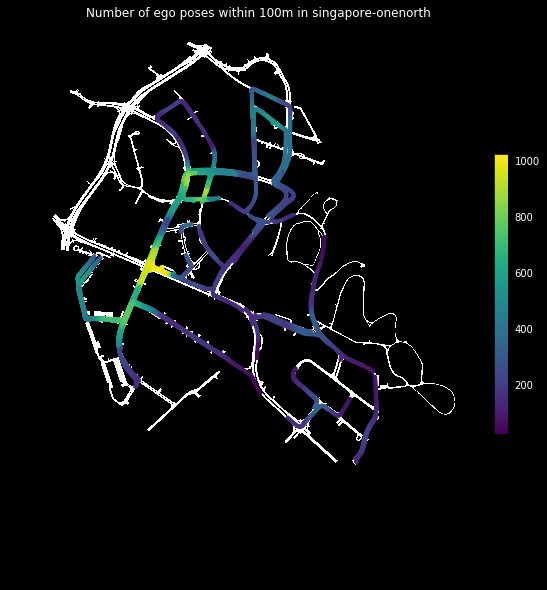

In [6]:
nusc_all.render_egoposes_on_map('singapore-onenorth')

  0%|          | 0/85 [00:00<?, ?it/s]

Adding ego poses to map...


100%|██████████| 85/85 [00:10<00:00,  8.07it/s]


Creating plot...


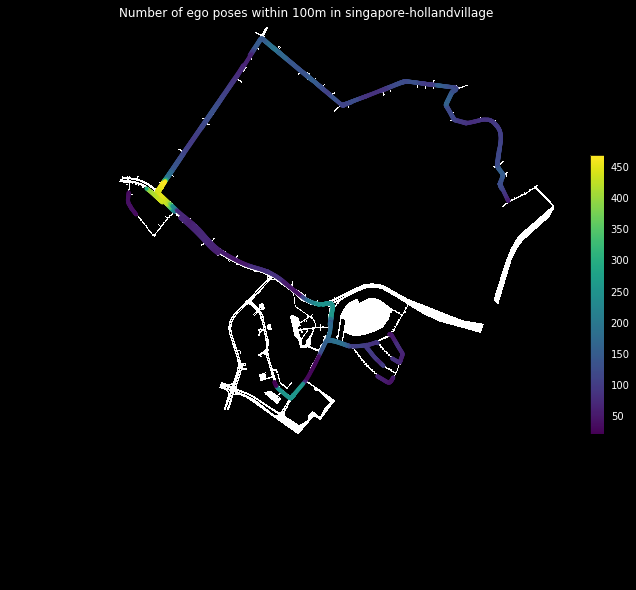

In [7]:
nusc_all.render_egoposes_on_map('singapore-hollandvillage')

In [8]:
nusc_all.render_egoposes_on_map('boston')

AssertionError: Error: This split has 0 scenes for location boston!

In [ ]:
nusc.visibility

In [ ]:
nusc_all.render_annotation('6525748cd1df4b97bf726bdb44f1cb73')

In [ ]:
len([s for s in nusc_all.sample_annotation if s['category_name'] == 'movable_object.barrier' and s['size'][1] > s['size'][0]])

In [ ]:
vis = [s['visibility_token'] for s in nusc_all.sample_annotation]

In [ ]:
import numpy as np
np.unique(vis)

In [ ]:
nusc.category

In [ ]:
nusc.render_egoposes_on_map('singapore-onenorth')

In [ ]:
nusc.list_attributes()

In [ ]:
len([s for s in nusc.sample_annotation if len(s['attribute_tokens']) > 0])

In [ ]:
cars = [s for s in nusc.sample_annotation if s['category_name'] == 'vehicle.car' and len(s['attribute_tokens']) == 0]
len(cars)

In [ ]:
for car in cars:
    sample = nusc.get('sample', car['sample_token'])
    scene = nusc.get('scene', sample['scene_token'])
    print(scene['name'])

In [ ]:
for car in cars:
    sample = nusc.get('sample', car['sample_token'])
    scene = nusc.get('scene', sample['scene_token'])
    #print(scene['name'])
    if scene['name'] == 'scene-0747':
        print(car)

In [ ]:
nusc.render_annotation('4807107ff4f74d32933595152e9d01fc')

In [ ]:
vis = [s['visibility_token'] for s in nusc.sample_annotation]
vis

In [ ]:
from collections import Counter
Counter(vis)

In [ ]:
import numpy as np
np.sum([v == '' for v in vis])

In [ ]:
nusc.list_scenes()

In [ ]:
for scene in nusc.scene:
    print('%s\t%s' % (scene['name'], scene['description']))

In [ ]:
barriers = [sa for sa in nusc.sample_annotation if sa['category_name'] == 'movable_object.barrier']
barriers_bug = [sa for sa in barriers if sa['size'][1] > sa['size'][0]]
assert len(barriers_bug) == 0

In [ ]:
barriers[0]

In [ ]:
barriers_bug[2500] # use this one for vis

In [ ]:
nusc.render_annotation(barriers_bug[2500]['token'])

In [ ]:
nusc.get('instance', '7439e973ce2f4f38b78e4f1da63077b5')

In [ ]:
nusc.get('category', '653f7efbb9514ce7b81d44070d6208c1')

In [ ]:
nusc.get('sample_annotation', '6525748cd1df4b97bf726bdb44f1cb73')

In [ ]:
len([ins for ins in nusc.instance if ins['category_token'] == '653f7efbb9514ce7b81d44070d6208c1'])

In [ ]:
nusc.instance[0]

In [ ]:
nusc.instance[0]

## NuScenes Basics

In [ ]:
# The NuScenes class holds several tables. Each table is a list of records, and each record is a dictionary. 
# For example the first record of the category table is stored at
nusc.category[0]

In [ ]:
# The category table is simple: it just holds fields `name` and `description`. In addition it also has a `token` 
# field, which is a unique record identifier. Since the record is a dictionary, the token can be accessed like so:
cat_token = nusc.category[0]['token']

# If you know the token for any record in the DB you can retrieve the record by doing
nusc.get('category', cat_token)

In [ ]:
# As you notice, we have now recovered the same record!

In [ ]:
# OK, that was pretty easy. Let's try something harder. Let's look at the sample_annotation table.
nusc.sample_annotation[0]

In [ ]:
# As you can see this also has a `token` field (they all do). In addition, it has several fields of the format [
# a-z]*_token, e.g. instance_token. These are foreign keys in database speak, meaning they point to another table. 
# Using nusc.get() we can grab any of these in constant time. For example, let's look at the visibility record.
nusc.get('visibility', nusc.sample_annotation[0]['visibility_token'])

In [ ]:
# The visibility records informs of how much of the object was visible when it was annotated.

# Let's also grab the instance_token
one_instance = nusc.get('instance', nusc.sample_annotation[0]['instance_token'])
one_instance

In [ ]:
# This points to the instance table. This table enumerate the object _instances_ we have encountered in each 
# scene. This way we can connect all annotation of a particular object.

# If you look carefully at the README tables, you will see that the sample_annotation table points to the object table, 
# but the object table doesn't list all annotations that point to it. 

# So how can we recover all sample_annotations for a particular object? There are two ways:

# (1). Use nusc.field2token(). Let's try it:
ann_tokens = nusc.field2token('sample_annotation', 'instance_token', one_instance['token'])

# This returns a list of all sample_annotation records with the `instance_token` == one_instance['token'].
# Let's store these in a set for now
ann_tokens_field2token = set(ann_tokens)

ann_tokens_field2token

In [ ]:
# The nusc.field2token() method is generic and can be used in any similar situation.

# (2) For certain situation, we provide some reverse indices in the tables themselves. This is one such example. 
# The instance record has a field `first_annotation_token` which points to the first annotation in time of this 
# instance. Recovering this record is easy.
ann_record = nusc.get('sample_annotation', one_instance['first_annotation_token'])
ann_record

In [ ]:
# Now we can traverse all annotations of this instance using the "next" field. Let's try it. 
ann_tokens_traverse = set()
ann_tokens_traverse.add(ann_record['token'])
while not ann_record['next'] == "":
    ann_record = nusc.get('sample_annotation', ann_record['next'])
    ann_tokens_traverse.add(ann_record['token'])

# Finally, let's assert that we recovered the same ann_records as we did using nusc.field2token:
assert ann_tokens_traverse == ann_tokens_field2token

## Reverse indexing and short-cuts

The nuScenes tables are normalized, meaning that each piece of information is only given once.
For example, there is one map record for each log record. Looking at the schema you will notice that the `map` table has a `log_token` field, but that the `log` table does not have a corresponding `map_token` field. But there are plenty of situations where you have a log, and want to find the corresponding map! So what to do? You can always use the `nusc.field2token()` method, but that is slow and inconvenient. We therefore add reverse mappings for some common situations including this one.

Further, there are situations where one needs to go through several tables to get a certain piece of information. 
Consider, for example, the category name (e.g. `human.pedestrian`) of a `sample_annotation`. The `sample_annotation` table doesn't hold this information since the category is an instance level constant. Instead the `sample_annotation` table points to a record in the `instance` table. This, in turn, points to a record in the `category` table, where finally the `name` fields stores the required information. Since it is quite common to want to know the category name of an annotation, we add a `category_name` field to the `sample_annotation` table during initialization of the NuScenes class.

In this section we list the short-cuts and reverse indices that are added to the `NuScenes` class during initialization. These are all created during in the `NuScenes.__make_reverse_index__()` method.

### Shortcuts

In [ ]:
# The sample_annotation table has a "category_name" shortcut:
catname = nusc.sample_annotation[0]['category_name']

ann_rec = nusc.sample_annotation[0]
inst_rec = nusc.get('instance', ann_rec['instance_token'])
cat_rec = nusc.get('category', inst_rec['category_token'])
print(catname == cat_rec['name'])

In [ ]:
# The sample_data table has "channel" and "sensor_modality" shortcuts:
channel = nusc.sample_data[0]['channel']

sd_rec = nusc.sample_data[0]
cs_record = nusc.get('calibrated_sensor', sd_rec['calibrated_sensor_token'])
sensor_record = nusc.get('sensor', cs_record['sensor_token'])
print(channel == sensor_record['channel'])

### Reverse indices
We add two reverse indices by default.
* A `map_token` field is added to the `log` records.
* The `sample` records have shortcuts to all `sample_annotations` for that record as well as `sample_data` key-frames. Confer `nusc.list_sample()` method in next section for more details on this.

## Data Visualizations

We provide a set of list and rendering methods. These are meant both as convenience methods during development and as tutorials for building your own. They are implemented in the NuScenesExplorer class, with shortcuts through the NuScenes class itself.

### List methods
There are three list methods availble to look at certain aspects of the DB.

In [ ]:
# list_categories() lists all categories, counts and statistics of width/length/height in meters and aspect ratio.
nusc.list_categories()

In [ ]:
# list_attributes() lists all attributes and counts.
nusc.list_attributes()

In [ ]:
# list_scenes() lists all scenes in the DB.
nusc.list_scenes()

In [ ]:
# list_sample() lists all related sample_data keyframes and annotation associated with a sample
nusc.list_sample(nusc.sample[0]['token'])

### Render

In [ ]:
# First, let's plot a lidar point cloud in an image.
# Lidar allows us to accurate map the surroundings in 3D.
my_sample = nusc.sample[4]
nusc.render_pointcloud_in_image(my_sample['token'], pointsensor_channel='LIDAR_TOP')

In [ ]:
# Second, let's plot the radar point cloud for the same image.
# Radar is less dense than lidar, but has a much larger range.
my_sample = nusc.sample[1300]
nusc.render_pointcloud_in_image(my_sample['token'], pointsensor_channel='RADAR_FRONT')

In [ ]:
# We can also plot all annotations across all sample data for that sample.
# Note how for radar we also plot the velocity vectors of moving objects.
# Some velocity vectors are outliers, which can be filtered using the settings in RadarPointCloud.from_file().
my_sample = nusc.sample[2958]
nusc.render_sample(my_sample['token'])

In [ ]:
# Or if we only want to render a particular sensor, we can specify that.
nusc.render_sample_data(my_sample['data']['CAM_FRONT'])

In [ ]:
# Additionally we can aggregate the point clouds from multiple sweeps to get a denser point cloud.
nusc.render_sample_data(my_sample['data']['LIDAR_TOP'], nsweeps=5)
nusc.render_sample_data(my_sample['data']['RADAR_FRONT_RIGHT'], nsweeps=5)

In [ ]:
# We can even render a specific annotation.
nusc.render_annotation('8da80cfb6ee84e51b8428c03d04b930e')

In [ ]:
sample = nusc.get('sample', '0146886239d249818d7093e2146b8128')
scene = nusc.get('scene', sample['scene_token'])
sample

In [ ]:
scene

In [ ]:
import numpy as np

In [ ]:
[sat for sat in sample['anns'] if np.sqrt(np.sum(nusc.box_velocity(sat) ** 2)) > 8]

In [ ]:
nusc.render_annotation('2324163e59934c978bf76f7d1f397da1')

In [ ]:
# Finally, we can render a full scene as a video. There are two options here. 
# (1) nusc.render_scene_channel() renders the video for a particular channel. (HIT ESC to exit)
# (2) nusc.render_scene() renders the video for all camera channels.
# NOTE: These methods use OpenCV for rendering, which doesn't always play nice with IPython Notebooks. 
# If you experience any issues please run these lines from the command line. 

# Let's grab scene 0043, it is nice and dense.
my_scene_token = nusc.field2token('scene', 'name', 'scene-0043')[0]
nusc.render_scene_channel(my_scene_token, 'CAM_FRONT')

In [ ]:
# There is also a method nusc.render_scene() which renders the video for all camera channels. 
# This requires a high-res monitor, and is also best run outside this notebook.
nusc.render_scene(my_scene_token)

In [ ]:
# Finally, let us visualize all scenes on the map for a particular location.
nusc.render_egoposes_on_map(log_location='singapore-onenorth')